## Pneumonia Detection using PyTorch

###  Special thanks to Paul Mooney for Datasets on Chest-Xray images for Pneumonia !!

Here is the link to dataset. https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia#chest_xray.zip

### Header declarations and detect  CUDA 

In [1]:
import os
import torch
from torch import nn
import numpy as np

import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()
device='cpu'

if train_on_gpu:
    print("Cuda is available")
    device='cuda'
else:
    print("CPU is available")



Cuda is available


###  Load Images from root folder and pre-process them and create DataLoaders

Transforms
When you load in the data with ImageFolder, you'll need to define some transforms. For example, the images are different sizes but we'll need them to all be the same size for training. You can either resize them with transforms.Resize() or crop with transforms.CenterCrop(), transforms.RandomResizedCrop(), etc. We'll also need to convert the images to PyTorch tensors with transforms.ToTensor().

In [2]:
# define training and test data directories
data_dir = 'chest_xray'
train_dir = os.path.join(data_dir, 'train/')
test_dir = os.path.join(data_dir, 'test/')
val_dir = os.path.join(data_dir, 'val/')

#preprocess and convert to tensor
data_transform = transforms.Compose([transforms.RandomResizedCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

#load and transform data from given path
train_data = datasets.ImageFolder(train_dir, transform=data_transform)
test_data =  datasets.ImageFolder(test_dir,transform=data_transform)
val_data =  datasets.ImageFolder(val_dir,transform=data_transform)


#create DataLoaders for training set and test set
train_loader = torch.utils.data.DataLoader(train_data,batch_size=32,shuffle=True)
test_loader  = torch.utils.data.DataLoader(test_data,batch_size=32,shuffle=True)
val_loader  = torch.utils.data.DataLoader(test_data,batch_size=32,shuffle=True)


### Visualize data from test and train loaders

C:\ProgramData\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  # This is added back by InteractiveShellApp.init_path()
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range fo

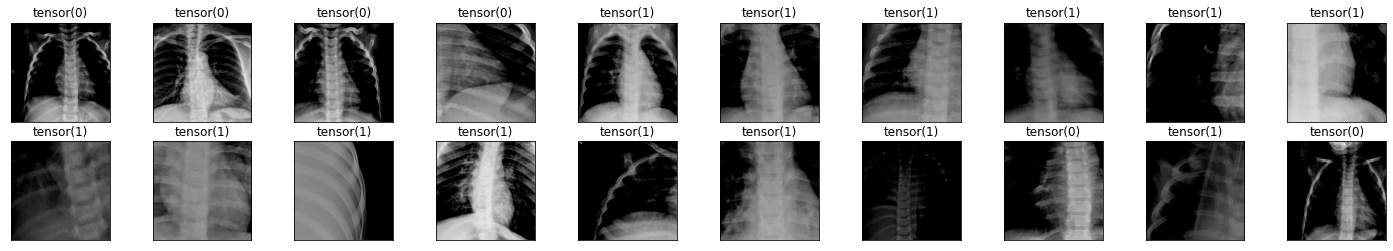

In [3]:
# Visualize some sample data

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(labels[idx])

### Create A CNN architecture 
defining a model from scratch. This may not be nearly good enough for detecting infection.But let's just give it a try. 
The architecture has 5 Convolution layers, each convolution layer uses RELU activation function, followed by maxpool that reduces the width and height of input by a factor of 2. 

Final layers are 2 fully connected Linear layers with droput of 0.2 and again uses relu activation. 

We can compute the spatial size of the output volume as a function of the input volume size (W), the kernel/filter size (F), the stride with which they are applied (S), and the amount of zero padding used (P) on the border. The correct formula for calculating how many neurons define the output_W is given by (W−F+2P)/S+1.

For example for a 7x7 input and a 3x3 filter with stride 1 and pad 0 we would get a 5x5 output. With stride 2 we would get a 3x3 output.

In [4]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class XRayNet(nn.Module):
    def __init__(self):
        super(XRayNet, self).__init__()
        # convolutional layer (sees 224x224*1 image tensor)
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        # convolutional layer (sees 112*112*16 image tensor)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        # convolutional layer (sees 56*56*32 image tensor)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        # convolutional layer (sees 28*28*64 image tensor)
        self.conv4 = nn.Conv2d(64, 128, 3, padding=1)
        # convolutional layer (sees 14*14*128 image tensor)
        self.conv5 = nn.Conv2d(128, 256, 3, padding=1)
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # linear layer (7 * 7 * 256)
        self.fc1=nn.Linear(7 * 7 * 256,200)
        # linear layer (7 * 7 * 256)
        self.fc2=nn.Linear(200,2)
        #dropout layer
        self.dropout=nn.Dropout(0.2)
        
    def forward(self,x):
        # add sequence of convolutional and max pooling layers
        x= self.pool(F.relu(self.conv1(x)))
        x= self.pool(F.relu(self.conv2(x)))
        x= self.pool(F.relu(self.conv3(x)))
        x= self.pool(F.relu(self.conv4(x)))
        x= self.pool(F.relu(self.conv5(x)))
        # flatten image input
        x = x.view(-1, 256 * 7 * 7)
        
        # first fully connected layer
        x= self.dropout(x)
        x= F.relu(self.fc1(x))
        # second fully connected layer
        x= self.dropout(x)
        x= F.relu(self.fc2(x))
        return x
    
# create a complete CNN
model = XRayNet()
print(model)

# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()

XRayNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=12544, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=2, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


### Specify Loss Function and Optimizer


In [5]:
import torch.optim as optim

# specify loss function (categorical cross-entropy)
criterion =  nn.CrossEntropyLoss()

# specify optimizer
optimizer = optim.Adam(model.parameters(),lr=0.001) #optim.SGD(model.parameters(), lr=0.01)

### Train your Network

In [6]:
num_epochs=20

for epoch in range(1,num_epochs):
    train_loss=0.0
    for images,labels in train_loader:
        images,labels=images.cuda(),labels.cuda()
        # reset to calculate new weights
        optimizer.zero_grad()
        #forward pass
        output=model(images)
        # calculate the batch loss
        loss = criterion(output, labels)
         # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*images.size(0)
    # calculate average losses
    train_loss = train_loss/len(train_loader.sampler)
    print('For Epoch {} \t training loss is {:.6f}'.format(epoch,train_loss))

For Epoch 1 	 training loss is 0.503351
For Epoch 2 	 training loss is 0.429022
For Epoch 3 	 training loss is 0.333164
For Epoch 4 	 training loss is 0.295650
For Epoch 5 	 training loss is 0.282589
For Epoch 6 	 training loss is 0.263374
For Epoch 7 	 training loss is 0.248661
For Epoch 8 	 training loss is 0.241428
For Epoch 9 	 training loss is 0.231278
For Epoch 10 	 training loss is 0.221525
For Epoch 11 	 training loss is 0.218979
For Epoch 12 	 training loss is 0.217420
For Epoch 13 	 training loss is 0.211075
For Epoch 14 	 training loss is 0.217455
For Epoch 15 	 training loss is 0.201372
For Epoch 16 	 training loss is 0.198781
For Epoch 17 	 training loss is 0.195703
For Epoch 18 	 training loss is 0.200690
For Epoch 19 	 training loss is 0.206712


### Test the Trained Network

In [18]:
# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(2) )
class_total = list(0. for i in range(2) )
batch_size =32
model.eval() # prep model for evaluation

for data, target in test_loader:
    # forward pass: compute predicted outputs by passing inputs to the model
    data,target=data.cuda(),target.cuda()
    output = model(data)
    # calculate the loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(len(target)):
        label = target.data[i]      
        label=label.item()
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss/len(test_loader.sampler)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(len(class_total)):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))
      



Test Loss: 0.424441

Test Accuracy of     0: 62% (147/234)
Test Accuracy of     1: 97% (381/390)

Test Accuracy (Overall): 84% (528/624)
